In [3]:
import numpy as np
import torch
import fvdb
import tqdm

# A starting point from the previous notebook:
batch_size = 8
num_voxels_per_grid = [np.random.randint(1_000, 10_000) for _ in range(batch_size)]

# A list of randomly generated 3D indices for each grid in our batch in the range [-512, 512]
ijks = [torch.randint(-512, 512, (num_voxels_per_grid[i], 3), device='cuda') for i in range(batch_size)]

# Create an fvdb.GridBatch from the list of indices!!
grid = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks),
                                 voxel_sizes = [np.random.rand(3) for _ in range(batch_size)], # Random, different voxel sizes for each grid in our batch
                                 origins     = [np.random.rand(3) for _ in range(batch_size)], # Random, different grid origins for each grid in our batch
                                )

# Random features
features = grid.jagged_like(torch.randn(grid.total_voxels, 32, device=grid.device))

### VDBTensor

As you can tell from the previous notebook, the functionality for `GridBatch` and `JaggedTensor` are closely related to each other and it's often the case you want to perform operations that reference or affect both the grid and feature data at the same time.  

To that end, `VDBTensor` exists to wrap around a `GridBatch` and `JaggedTensor` and provides most of the higher level functionality you'll use for these high level operations.

<center>

<img src="img/vdbtensor.svg"  alt="VDB Tensor" width="1000"/>>

</center>

Creating a `VDBTensor` is as simple as:

In [4]:
from fvdb.nn import VDBTensor

vdbtensor = VDBTensor(grid, features)

`VDBTensor` has some common functionality to both `GridBatch` and `JaggedTensor` such as moving to a device:
    
```python
    vdbtensor = vdbtensor.to(device)
    vdbtensor = vdbtensor.cuda()
```

Or retrieving the batch size and total number of active voxels:

```python
    num_grids = vdbtensor.grid_count
    num_voxels = vdbtensor.total_voxels
```

##### VDBTensor Operations

`VDBTensor` has a number of operations that are designed to work with both the `GridBatch` and `JaggedTensor` at the same time.  Concatenation is a useful example.

`VDBTensor` concatenation has two different definitions.

Concatenating along dimension 0 is a concatenation *along the batch dimension*.  So if `J1` has 10 member grids in the batch and `J2` has 20 members in the batch, then `VDBTensor.cat([J1,J2], dim=0)` will have 30 members.  All input `VDBTensors` must have the same number of features.

Concatenating along dimension 1 concatenates the features of the `VDBTensors` together.  So if `J1` has 3 features and `J2` has 4 features, then `VDBTensor.cat([J1,J2], dim=1)` will have 7 features.  All input `VDBTensors` must have the same number of grids in the batch and number of voxels in each grid.

In [5]:
print(f"Concatenating VDBTensor of batch size {vdbtensor.batch_size}, feature size {vdbtensor.jdata.shape[1]}, total voxels {vdbtensor.total_voxels} with itself along…")
print(f"\tdim 0 gives a VDBTensor of batch size {VDBTensor.cat([vdbtensor, vdbtensor]).batch_size}, feature size {VDBTensor.cat([vdbtensor, vdbtensor]).jdata.shape[1]}, and total voxel count {VDBTensor.cat([vdbtensor, vdbtensor]).total_voxels}.")
print(f"\tdim 1 gives a VDBTensor of batch size {VDBTensor.cat([vdbtensor, vdbtensor], dim=1).batch_size}, feature size {VDBTensor.cat([vdbtensor, vdbtensor], dim=1).jdata.shape[1]}, and total voxel count {VDBTensor.cat([vdbtensor, vdbtensor], dim=1).total_voxels}.")

Concatenating VDBTensor of batch size 8, feature size 32, total voxels 46193 with itself along…
	dim 0 gives a VDBTensor of batch size 16, feature size 32, and total voxel count 92386.
	dim 1 gives a VDBTensor of batch size 8, feature size 64, and total voxel count 46193.


####  NN Modules

Many commonly used Neural Network modules are available from `fvdb.nn`, operate on `VDBTensors` and return `VDBTensors`.  For example, `fvdb.nn.Conv3d` is a 3D convolutional layer and `fvdb.nn.Linear` is a fully connected layer.  

These modules are designed to work with `VDBTensors` and are a drop-in replacement for the PyTorch equivalents and can be used in combination with other PyTorch modules:

In [6]:
from fvdb.nn import LeakyReLU, Sigmoid, Linear

linear = torch.nn.Sequential(Linear(32, 64), LeakyReLU()).to('cuda')

out_vdbtensor = linear(vdbtensor)

print(f"Linear layer took a VDBTensor input of feature size {vdbtensor.jdata.shape[1]} and output feature size {out_vdbtensor.jdata.shape[1]}.")

Linear layer took a VDBTensor input of feature size 32 and output feature size 64.


In this simple example we took a `VDBTensor` (a pair of a `GridBatch` and `JaggedTensor`) and ran it through a fully-connected layer it to produce a new `VDBTensor` (another pair of a `GridBatch` and `JaggedTensor`).

It's worth noting that it would be wasteful to have two separate `GridBatch`s in this example because our `linear` operation hasn't actually changed the topology of the grids in any way, it has only produced new features.

In fact, the `fvdb.nn` modules consider best-practice optimizations such as this and you can see that the `GridBatch` of the input and output `VDBTensor` are in-fact the same objects on your device:

In [8]:
print("Input and output VDBTensor's GridBatches are the same: ", VDBTensor.same_grid(out_vdbtensor.grid, vdbtensor.grid))

Input and output VDBTensor's GridBatches are the same:  True


In practice, in the course of running a neural network it is often the case that there are several `JaggedTensors` which are produced that correspond to a single `GridBatch`.  

`fvdb.nn` will automatically handle these types of optimizations for you such as ensuring that only the new feature data is created when operations are performed which don't alter the topology of the input grid.

### Training a Simple Network

Let's train a simple network to classify the voxels in a grid as being inside or outside of a sphere using fVDB and all the standard PyTorch functionality.

In [ ]:
# DataSet that produces random grids centered at 0, 0, 0 worldspace with voxel sizes (0.01, 0.01, 0.01)
from torch.utils.data import Dataset
class RandomGridsDataset(Dataset):
    def __init__(self, batch_size):
        self.batch_size = batch_size
    def __len__(self):
        return 100
    def __getitem__(self, idx) -> VDBTensor:
        ijks = [torch.randint(-200, 200, (np.random.randint(5_000, 50_000), 3), device='cuda') for i in range(self.batch_size)]
        grid = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks), voxel_sizes=0.005)
        # features are the world-space coordinates of the voxels
        features = grid.grid_to_world(grid.ijk.float())
        return VDBTensor(grid, features)

# Define model
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc0 = Linear(3, 16)
        self.fc1 = Linear(3, 16)
        self.fc2 = Linear(32, 32)
        self.fc3 = Linear(32, 1)
        self.relu = LeakyReLU()
        self.sigmoid = Sigmoid()
    def forward(self, x):
        # concatenate the features produced by two different linear layers
        x = self.relu(VDBTensor.cat([self.fc0(x), self.fc1(x)], dim=1))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


# Data
dataset = RandomGridsDataset(batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=lambda x: x[0])

# Model, Loss, Optimizer
model = Model().to('cuda')

loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

epochs = 10
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            # JaggedTensor indicating whether each voxel is inside or outside of the unit sphere centered at the origin of the grid space
            dist = torch.sqrt(torch.sum(data.grid.grid_to_world(data.grid.ijk.float()).jdata ** 2, dim=1))
            target = (dist < 1).float()
            l = loss(output.feature.jdata, target[:, None])
            l.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch}, batch {i}, loss {l.item()}")
        pbar.update(1)


Epoch 9, batch 99, loss 0.04138416796922684: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Let's visualize a sample of predictions from the network to see how well it's doing.

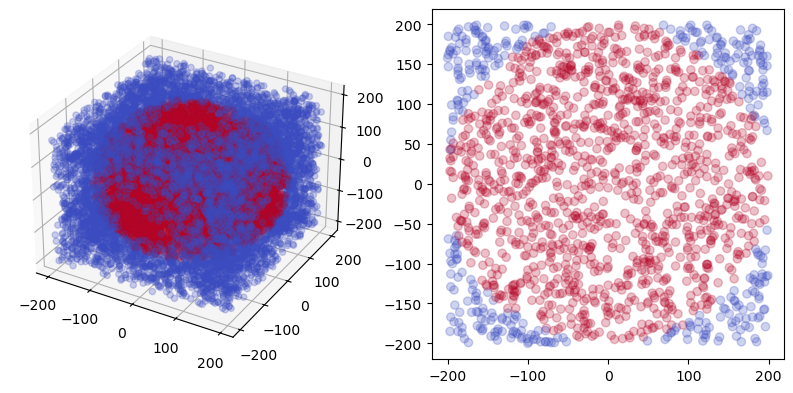

In [ ]:
import matplotlib.pyplot as plt

test_data = next(iter(dataloader))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2,2,1, projection='3d')

model.eval()
pred = model(test_data)

ijks_0 = pred.grid.ijk.jdata[pred.grid.jidx==0].detach().cpu().numpy()
pred_0 = pred.feature.jdata[pred.feature.jidx==0].detach().cpu()

preds_in_sphere = ijks_0[torch.round(pred_0)[:,-1] == 1]

ax.scatter3D(ijks_0[:, 0], ijks_0[:, 1], ijks_0[:, 2], marker = 'o', c = torch.round(pred_0), cmap='coolwarm', alpha =0.25)

pred_0 = pred_0[((ijks_0[:, 2]>-20) & (ijks_0[:, 2]<20))]

ijks_0 = ijks_0[((ijks_0[:, 2]>-20) & (ijks_0[:, 2]<20))]

ax = fig.add_subplot(2,2,2)
ax.scatter(ijks_0[:, 0], ijks_0[:, 1], c=torch.round(pred_0), marker = 'o', cmap='coolwarm', alpha=0.25)
fig.show()